In [1]:
import torch
import torch.nn as nn
import torch.distributions as distrib
import torchvision.transforms as transforms
import torchvision
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
img_rows = 28
img_cols = 28
channels = 1

# Input image dimensions
img_shape = (img_rows, img_cols, channels)

# Size of the noise vector, used as input to the Generator
z_dim = 100

# Number of classes in the dataset
num_classes = 10

In [4]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        num_channels = 1
        num_classes = 10
        in_channels = num_channels 

        self.model = nn.Sequential(
            # Convolutional layer, from 1x28x28 into 16x14x14 tensor
            nn.Conv2d(num_channels, 16, kernel_size=4, stride=2, padding=1),
            # Batch normalization
            nn.BatchNorm2d(16),
            # Leaky ReLU activation
            nn.LeakyReLU(0.01),
            #nn.Dropout(0.3),
            # Convolutional layer, from 16x14x14 into 32x7x7 tensor
            nn.Conv2d(16, 32, kernel_size=4, stride=2, padding=1),
            # Batch normalization
            nn.BatchNorm2d(32),     
            # Leaky ReLU activation
            nn.LeakyReLU(0.01),
            #nn.Dropout(0.3),
            #nn.Conv2d(32,1,kernel_size=7,stride=1),
            # 32x7x7 -> 1568
            nn.Flatten(start_dim=1),
            nn.Linear(32*7*7, 100),
            nn.BatchNorm1d(100),
            nn.LeakyReLU(0.01),
            nn.Linear(100, 1),

            #nn.Conv2d(128,256,kernel_size=3,stride=2,padding=1),
            # Batch normalization
            #nn.BatchNorm2d(256),     
            # Leaky ReLU activation
            #nn.LeakyReLU(0.01),
  
            # Output layer with sigmoid activation
            #nn.Flatten(),
            nn.Sigmoid()
        )


    def forward(self, x):
        # convertit le tenseur (batch, 784) en (batch, 1, 28, 28)
        x = x.view(x.size(0), 1, 28, 28)
        #x = x.Reshape(1,28,28)
        #c = self.label_embedding(labels)
        #c = c.view(x.size(0), 10, 28, 28)
        #c = c.Reshape(10,28,28)
        #x = torch.cat([x, c], dim=1)
        output = self.model(x)
        #output = output.view(len(output),1)
        # applatit toutes les dimensions à partir de la n°1 en une seule dimension
        # convertit un tenseur (batch, 1, 1, 1) en un tenseur (batch, 1)
        #output = output.flatten(start_dim=1)
        return output

In [5]:
discriminator = Discriminator().to(device)
print(discriminator)

Discriminator(
  (model): Sequential(
    (0): Conv2d(1, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=1568, out_features=100, bias=True)
    (8): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.01)
    (10): Linear(in_features=100, out_features=1, bias=True)
    (11): Sigmoid()
  )
)


In [6]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        latent_dim = 100
        num_classes = 10
        input_dim = latent_dim 

        self.model = nn.Sequential(
            # Reshape input into 7x7x256 tensor via a fully connected layer
            #nn.Linear(z_dim,256*7*7),
            #Reshape((256,7,7,)),
            #nn.BatchNorm1d(7*7*256),
            #nn.ReLU(),
            #  100x1x1 -> 128x7x7
            nn.ConvTranspose2d(latent_dim, 128, kernel_size=7,stride=1),#,padding=1,output_padding=1)
            nn.BatchNorm2d(128),
            nn.ReLU(),
            # Transposed convolution layer, from 7x7x256 into 14x14x128 tensor
            # 128x7x7 -> 64x14x14
            nn.ConvTranspose2d(128,64,kernel_size=4,stride=2,padding=1),  #,padding=1,output_padding=1),
            # Batch normalization
            nn.BatchNorm2d(64),
            # Leaky ReLU activation
            nn.ReLU(),
            # Transposed convolution layer, from 14x14x128 to 14x14x64 tensor
            # 64x14x14 -> 32x28x28
            nn.ConvTranspose2d(64,32,kernel_size=4,stride=2,padding=1),   #,padding=1),
            # Batch normalization
            nn.BatchNorm2d(32),
            # Leaky ReLU activation
            nn.ReLU(),
            # Transposed convolution layer, from 14x14x64 to 28x28x1 tensor
            #nn.ConvTranspose2d(64,1,kernel_size=4,stride=2),   #,padding=1,output_padding=1),
            nn.Conv2d(32, 1, kernel_size=5, stride=1, padding=2),
            # Output layer with tanh activation
            nn.Tanh()
        )
        

    def forward(self, x):
        #c = self.label_embedding(labels)
        #x = torch.cat([x,c], 1)
        #output = self.fc(x)
        #output = output.view(-1, 256, 7, 7)
        x=x.view(x.size(0),z_dim,1,1)
        output = self.model(x)
        #output = output.view(-1, 1, 28, 28)
        return output

In [7]:
generator = Generator().to(device)
print(generator)

Generator(
  (model): Sequential(
    (0): ConvTranspose2d(100, 128, kernel_size=(7, 7), stride=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv2d(32, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (10): Tanh()
  )
)


In [8]:
lr_g = 1e-4
lr_d = 1e-5
lr = 1e-4
num_epochs = 50
loss_function = nn.MSELoss()
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr,betas = (0.5,0.9))   
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr,betas = (0.5,0.9))

In [9]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

batch_size = 32
# Load the training set
train_set = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
# Create a batched data loader
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)

In [10]:
latent_space_samples_plot = torch.randn((batch_size, 100)).to(device=device)

Epoch: 0 Loss D.: 0.25244683027267456
Epoch: 0 Loss G.: 0.25851982831954956


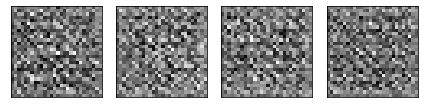

Epoch: 1 Loss D.: 0.18066570162773132
Epoch: 1 Loss G.: 0.3654196560382843


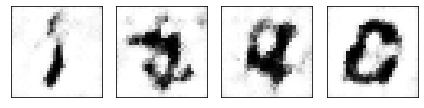

Epoch: 2 Loss D.: 0.1645030975341797
Epoch: 2 Loss G.: 0.3959100842475891


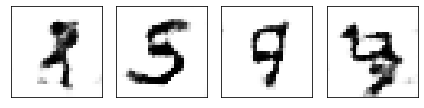

Epoch: 3 Loss D.: 0.18969297409057617
Epoch: 3 Loss G.: 0.3729512691497803


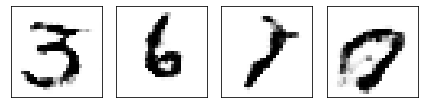

Epoch: 4 Loss D.: 0.18274512887001038
Epoch: 4 Loss G.: 0.3731119632720947


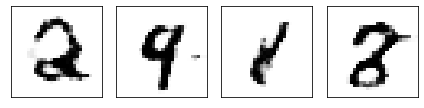

Epoch: 5 Loss D.: 0.210819274187088
Epoch: 5 Loss G.: 0.4101760685443878


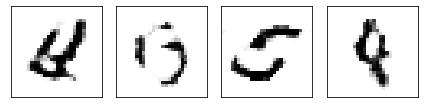

Epoch: 6 Loss D.: 0.2009061574935913
Epoch: 6 Loss G.: 0.3383632004261017


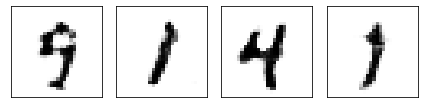

Epoch: 7 Loss D.: 0.18844269216060638
Epoch: 7 Loss G.: 0.44363993406295776


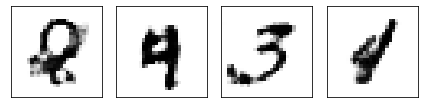

Epoch: 8 Loss D.: 0.17707031965255737
Epoch: 8 Loss G.: 0.4166850447654724


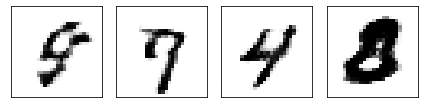

Epoch: 9 Loss D.: 0.21617209911346436
Epoch: 9 Loss G.: 0.3898128271102905


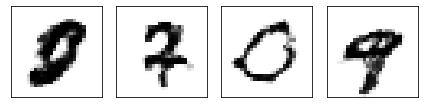

Epoch: 10 Loss D.: 0.17856261134147644
Epoch: 10 Loss G.: 0.35096657276153564


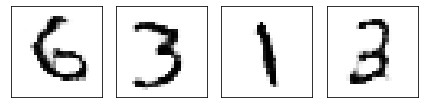

Epoch: 11 Loss D.: 0.18799741566181183
Epoch: 11 Loss G.: 0.3969368636608124


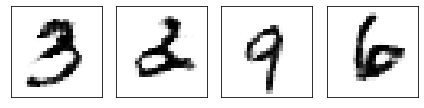

Epoch: 12 Loss D.: 0.19395354390144348
Epoch: 12 Loss G.: 0.38252270221710205


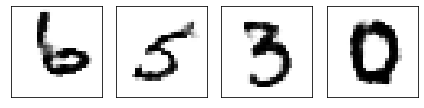

Epoch: 13 Loss D.: 0.17726477980613708
Epoch: 13 Loss G.: 0.39290910959243774


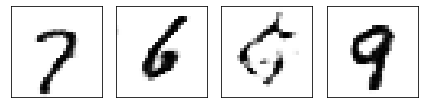

Epoch: 14 Loss D.: 0.2650264501571655
Epoch: 14 Loss G.: 0.3290945291519165


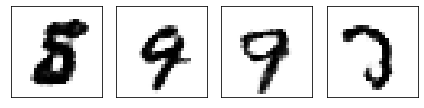

Epoch: 15 Loss D.: 0.166887104511261
Epoch: 15 Loss G.: 0.47336694598197937


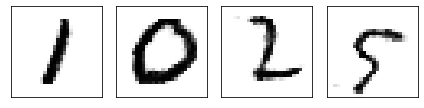

Epoch: 16 Loss D.: 0.20163428783416748
Epoch: 16 Loss G.: 0.392505407333374


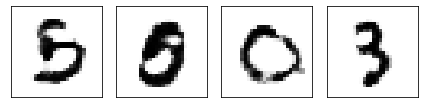

Epoch: 17 Loss D.: 0.13777203857898712
Epoch: 17 Loss G.: 0.45903605222702026


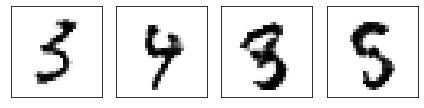

Epoch: 18 Loss D.: 0.177573099732399
Epoch: 18 Loss G.: 0.3785824179649353


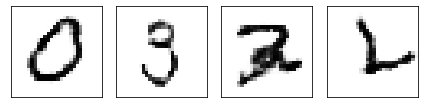

Epoch: 19 Loss D.: 0.18060636520385742
Epoch: 19 Loss G.: 0.43586692214012146


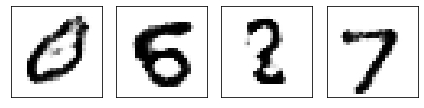

Epoch: 20 Loss D.: 0.2158278524875641
Epoch: 20 Loss G.: 0.379841148853302


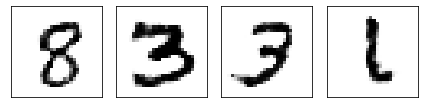

Epoch: 21 Loss D.: 0.16755928099155426
Epoch: 21 Loss G.: 0.45818549394607544


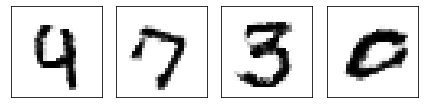

Epoch: 22 Loss D.: 0.2129240334033966
Epoch: 22 Loss G.: 0.471183180809021


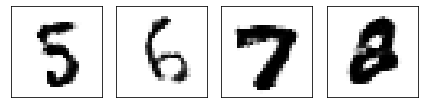

Epoch: 23 Loss D.: 0.2225867509841919
Epoch: 23 Loss G.: 0.405281662940979


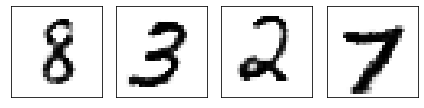

Epoch: 24 Loss D.: 0.15110015869140625
Epoch: 24 Loss G.: 0.45750993490219116


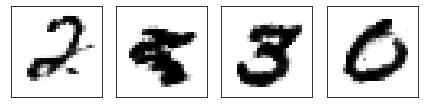

Epoch: 25 Loss D.: 0.18536357581615448
Epoch: 25 Loss G.: 0.39491701126098633


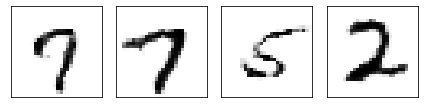

Epoch: 26 Loss D.: 0.1930214762687683
Epoch: 26 Loss G.: 0.43887442350387573


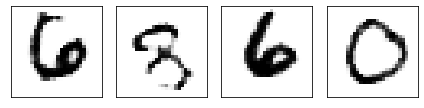

Epoch: 27 Loss D.: 0.2307388037443161
Epoch: 27 Loss G.: 0.41031724214553833


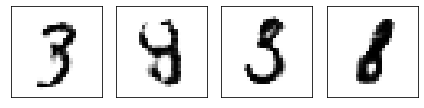

Epoch: 28 Loss D.: 0.18175968527793884
Epoch: 28 Loss G.: 0.40802884101867676


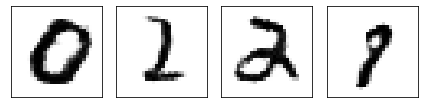

Epoch: 29 Loss D.: 0.1570151150226593
Epoch: 29 Loss G.: 0.37727928161621094


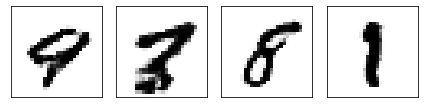

Epoch: 30 Loss D.: 0.16997051239013672
Epoch: 30 Loss G.: 0.4517976939678192


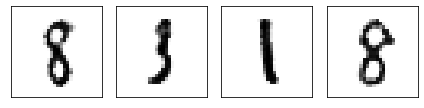

Epoch: 31 Loss D.: 0.18241697549819946
Epoch: 31 Loss G.: 0.4903770089149475


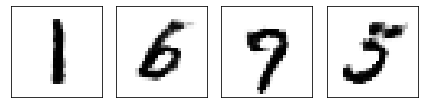

Epoch: 32 Loss D.: 0.18949367105960846
Epoch: 32 Loss G.: 0.5446690320968628


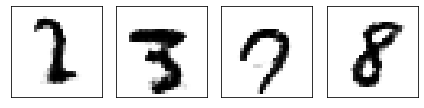

Epoch: 33 Loss D.: 0.1760084331035614
Epoch: 33 Loss G.: 0.4941791296005249


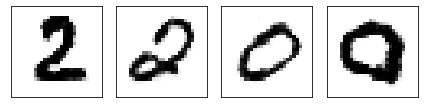

Epoch: 34 Loss D.: 0.2136566936969757
Epoch: 34 Loss G.: 0.42508119344711304


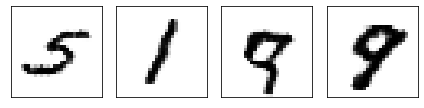

Epoch: 35 Loss D.: 0.1821085810661316
Epoch: 35 Loss G.: 0.42012909054756165


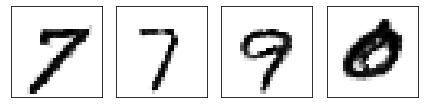

Epoch: 36 Loss D.: 0.16241614520549774
Epoch: 36 Loss G.: 0.4872641861438751


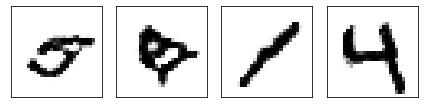

Epoch: 37 Loss D.: 0.16682890057563782
Epoch: 37 Loss G.: 0.42582204937934875


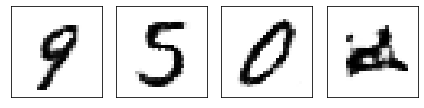

Epoch: 38 Loss D.: 0.15239842236042023
Epoch: 38 Loss G.: 0.47357213497161865


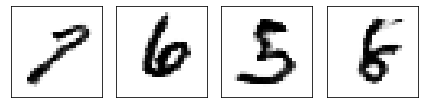

Epoch: 39 Loss D.: 0.17745819687843323
Epoch: 39 Loss G.: 0.4874323010444641


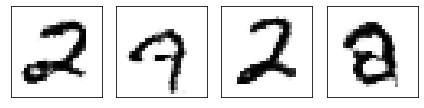

Epoch: 40 Loss D.: 0.21871554851531982
Epoch: 40 Loss G.: 0.44846856594085693


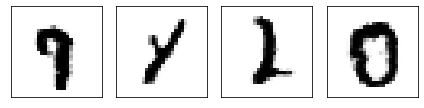

Epoch: 41 Loss D.: 0.16726259887218475
Epoch: 41 Loss G.: 0.4515692889690399


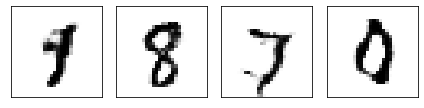

Epoch: 42 Loss D.: 0.1853264719247818
Epoch: 42 Loss G.: 0.48124009370803833


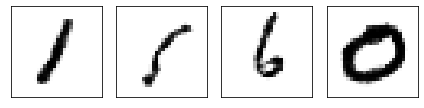

Epoch: 43 Loss D.: 0.1683521866798401
Epoch: 43 Loss G.: 0.41780194640159607


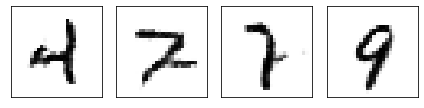

Epoch: 44 Loss D.: 0.11972875893115997
Epoch: 44 Loss G.: 0.5767703056335449


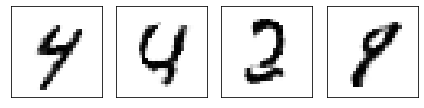

Epoch: 45 Loss D.: 0.20815865695476532
Epoch: 45 Loss G.: 0.3590952455997467


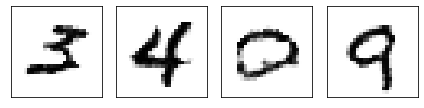

Epoch: 46 Loss D.: 0.14433223009109497
Epoch: 46 Loss G.: 0.487265020608902


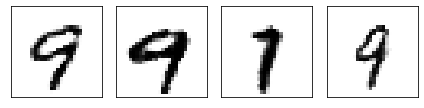

Epoch: 47 Loss D.: 0.19759006798267365
Epoch: 47 Loss G.: 0.4256978929042816


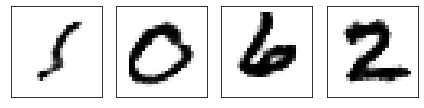

Epoch: 48 Loss D.: 0.18695807456970215
Epoch: 48 Loss G.: 0.47912460565567017


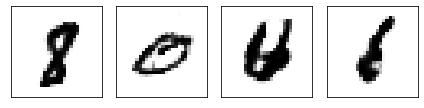

Epoch: 49 Loss D.: 0.15010501444339752
Epoch: 49 Loss G.: 0.49221059679985046


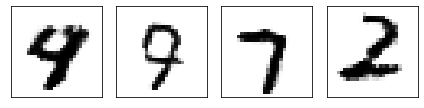

In [11]:
import os

loss_d = np.zeros(num_epochs)
loss_g = np.zeros(num_epochs)

# Load trained NN when it exists, or train a new NN
if os.path.isfile('discriminator.pt') and os.path.isfile('generator.pt'):
    discriminator.load_state_dict(torch.load('./discriminator.pt'))
    generator.load_state_dict(torch.load('./generator.pt'))   
else:
    for epoch in range(num_epochs):
      for n, (real_samples, mnist_labels) in enumerate(train_loader):
          ##############################
          ## update the discriminator
          ##############################
          batch_size = real_samples.size(0)
          noise = torch.randn((batch_size, 100))
          noise = noise.to(device)

          real_samples = real_samples.to(device)
          mnist_labels = mnist_labels.to(device)
          
          # zero the parameter gradients
          optimizer_discriminator.zero_grad()
          
          # forward du generator, creation d'un batch de fake samples (noise, puis passage dans generateur)
          fake_samples = generator(noise)
          
          # forward du discriminator

          disc_real_output = discriminator(real_samples)
          #print(fake_samples.size())
          disc_fake_output = discriminator(fake_samples.detach()) # on detach fake_samples, car on n'a pas 
                                                                                # besoin d'avoir accès au gradient du generateur
          
          # calculate the loss for the discriminator
          loss_discriminator = 1/2 * (loss_function(disc_real_output, torch.ones_like(disc_real_output)) + loss_function(disc_fake_output, torch.zeros_like(disc_fake_output)))
          loss_d[epoch] = loss_discriminator

          # calculate the gradient for the discriminator
          loss_discriminator.backward()  
          
          # update the discriminator first
          optimizer_discriminator.step()
          
          ##############################
          ## update the Generator
          ##############################
          
          # zero the parameter gradients
          optimizer_generator.zero_grad()

          # forward du discriminator
          # on ne detach pas fake_samples, car on veut garder les gradient pour pouvoir entrainer le generateur
          #print(fake_samples.size())
          disc_fake_output = discriminator(fake_samples)
          
          # calculate the loss for the generator
          loss_generator = loss_function(disc_fake_output, torch.ones_like(disc_fake_output),)
          loss_g[epoch] = loss_generator

          # calculate the gradient for the discriminator
          loss_generator.backward() 
          
          # update the generator
          optimizer_generator.step()

          # Show loss
          if n == batch_size - 1:
              print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
              print(f"Epoch: {epoch} Loss G.: {loss_generator}")
              
              latent_space_samples = torch.randn(batch_size, 100).to(device=device)

              generated_samples = generator(latent_space_samples)
              generated_samples = generated_samples.cpu().detach()

              plt.figure()
              for i in range(4):
                  ax = plt.subplot(1, 4, i+1)
                  plt.imshow(generated_samples[i].reshape(28, 28), cmap='gray_r')
                  plt.xticks([])
                  plt.yticks([])
              plt.tight_layout()
              plt.show()

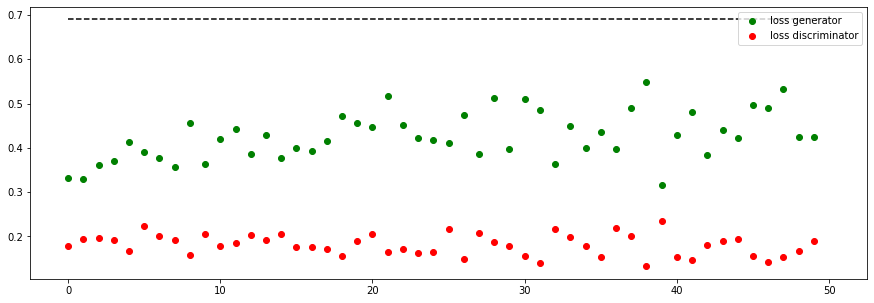

In [12]:
plt.figure(figsize=(15,5))
plt.plot(loss_g,'go', label = "loss generator")
plt.plot(loss_d, 'ro', label = "loss discriminator")
plt.hlines(0.69, 0,50,color='black', linestyle ='--')
plt.legend()

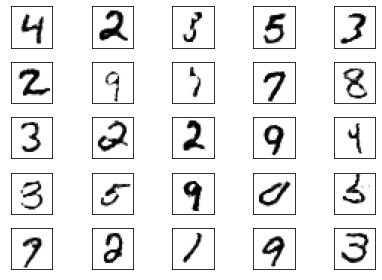

In [14]:
latent_space_samples = torch.randn(batch_size, 100).to(device=device)

generated_samples = generator(latent_space_samples)
generated_samples = generated_samples.cpu().detach()

plt.figure()
for i in range(25):
    ax = plt.subplot(5, 5, i+1)
    plt.imshow(generated_samples[i].reshape(28, 28), cmap='gray_r')
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()